# Predict low, high strategy  EDA

To install conda and binance packages to this notebook uncomment the code below

In [1]:
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
%pip install plotly==5.9.0
%pip install twisted
%pip install binance-connector==1.13.0
%pip install pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Init binance client

In [2]:
from binance.spot import Spot as Client
import os
import sys
import yaml

# Load 
def load_config():
    """
    Load config from cfg folder respecting the order: defaults, app.yaml, environment vars
    """
    # Defaults
    cfg_dir="./../biml/cfg"
    default_cfg_path = f"{cfg_dir}/app-defaults.yaml"
    with open(default_cfg_path, "r") as appdefaults:
        config = yaml.safe_load(appdefaults)

    # Custom config, should contain custom information,
    cfg_path = f"{cfg_dir}/app.yaml"
    if os.path.exists(cfg_path):
        with open(cfg_path) as app:
            config.update(yaml.safe_load(app))
    else:
        sys.exit(
            f"Config {cfg_path} not found. Please copy cfg/app-defaults.yaml to {cfg_path} "
            f"and update connection info there.")

    # Enviroment variabless
    config.update(os.environ)
    return config

def create_client(strategy: str):
        # Create binance client
        config=load_config()
        strategy=strategy.lower()
        key,secret,url=config[f"biml.connector.{strategy}.key"],config[f"biml.connector.{strategy}.secret"],config["biml.connector.url"]
        return Client(key=key, secret=secret, base_url=url, timeout=10)

#strategy="SimpleKerasStrategy"
strategy="LSTMStrategy"

client = create_client(strategy)



## Account and orders

In [3]:
account=client.account()
usdt_free=[a["free"] for a in account["balances"] if a["asset"]=="USDT"]
# update_time=account["update_time"]
# print(f"account update time:{update_time}")
print(f"My USDT amount: {usdt_free}")

print(account)
print(str(pd.to_datetime(account["updateTime"], unit="ms")))
# btc 1.15798200
#usdt 5134.30859706 26.04.2023 14:26



My USDT amount: ['10000.00167000']
{'makerCommission': 0, 'takerCommission': 0, 'buyerCommission': 0, 'sellerCommission': 0, 'commissionRates': {'maker': '0.00000000', 'taker': '0.00000000', 'buyer': '0.00000000', 'seller': '0.00000000'}, 'canTrade': True, 'canWithdraw': False, 'canDeposit': False, 'brokered': False, 'requireSelfTradePrevention': False, 'updateTime': 1683225395095, 'accountType': 'SPOT', 'balances': [{'asset': 'BNB', 'free': '1000.00000000', 'locked': '0.00000000'}, {'asset': 'BTC', 'free': '1.00000000', 'locked': '0.00000000'}, {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'}, {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'}, {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'}, {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'}, {'asset': 'USDT', 'free': '10000.00167000', 'locked': '0.00000000'}, {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}], 'permissions': ['SPOT']}
2023-05-04 18:3

My trades from Binance

In [4]:
symbol="BTCUSDT"
mytrades=pd.DataFrame(client.my_trades(symbol))
mytrades["time"] = pd.to_datetime(mytrades["time"], unit='ms')
mytrades.tail(100)


,symbol,id,orderId,orderListId,price,qty,quoteQty,commission,commissionAsset,time,isBuyer,isMaker,isBestMatch
0,BTCUSDT,245505,610393,-1,28774.20000000,0.00100000,28.77420000,0.00000000,USDT,2023-05-04 18:36:12.037,False,False,True
1,BTCUSDT,245530,610400,980,28776.99000000,0.00100000,28.77699000,0.00000000,BTC,2023-05-04 18:36:19.268,True,False,True
2,BTCUSDT,245536,610490,-1,28776.98000000,0.00100000,28.77698000,0.00000000,USDT,2023-05-04 18:36:25.606,False,False,True
3,BTCUSDT,245553,610496,981,28772.52000000,0.00100000,28.77252000,0.00000000,BTC,2023-05-04 18:36:35.095,True,True,True


Trades from bot database

In [5]:
import pandas as pd
import numpy as np

def get_trades(strategy: str):
    import sqlite3
    db_path=f"../data/{strategy}/{strategy}.db"

    with sqlite3.connect(db_path) as conn:
        trades=pd.read_sql_query("SELECT * FROM trade ORDER BY open_time",conn,
                                 parse_dates=["open_time", "close_time"])#.set_index("open_time", drop=False)
    trades["profit"] = np.where(trades["side"] == "BUY", 
                                trades["close_price"]-trades["open_price"],
                                trades["open_price"]-trades["close_price"],
                               )
    return trades

trades=get_trades(strategy)
trades.tail()

,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,profit
212,213,BTCUSDT,BUY,2023-04-27 03:54:34.036033,29003.38,11609618,29001.885940,29011.590538,11273,None,0.001,2023-04-27 03:55:44.315,29001.23,11609625,-2.15
213,214,BTCUSDT,BUY,2023-04-27 03:58:20.758029,28854.39,11611143,28852.519743,28858.854886,11274,None,0.001,2023-04-27 03:58:24.291,28858.85,11611147,4.46
214,215,BTCUSDT,BUY,2023-04-27 04:17:23.159605,28972.90,11617003,28969.813397,28991.619364,11275,None,0.001,2023-04-27 04:18:21.407,28969.24,11617004,-3.66
215,216,BTCUSDT,SELL,2023-05-04 18:36:12.939360,28774.20,610393,28775.959109,28769.768048,980,None,0.001,2023-05-04 18:36:19.268,28776.99,610400,-2.79
216,217,BTCUSDT,SELL,2023-05-04 18:36:26.510163,28776.98,610490,28778.570672,28772.521057,981,None,0.001,2023-05-04 18:36:35.095,28772.52,610496,4.46


In [6]:
print(f"Total profit: {trades['profit'].sum()}")

Total profit: -282.39000000002125


Opened trades from trade bot database

In [7]:
trades[trades.close_time.isna()].tail()

,id,ticker,side,open_time,open_price,open_order_id,stop_loss_price,take_profit_price,stop_loss_order_id,trailing_delta,quantity,close_time,close_price,close_order_id,profit


In [8]:
#trades[["open_price", "close_price"]].tail()
#(trades["open_price"] - trades["take_profit_price"]).abs().max()
#trades[["open_price", "stop_loss_price"]].info()
#df["stop_loss"] = df["open_price"].astype(float) - df["stop_loss_price"].astype(float)
#df["stop_loss"] = df["stop_loss"].abs()


#df.info()

Last orders, provided by Binance

In [9]:
orders = pd.DataFrame(client.get_orders(symbol))
for timecol in ["time", "updateTime", "workingTime"]:
    orders[timecol] = pd.to_datetime(orders[timecol], unit='ms')
orders.tail()

,symbol,orderId,orderListId,clientOrderId,price,origQty,executedQty,cummulativeQuoteQty,status,timeInForce,type,side,stopPrice,icebergQty,time,updateTime,isWorking,workingTime,origQuoteOrderQty,selfTradePreventionMode
6,BTCUSDT,610400,980,28kUfgfUr1JowhIiKGX78R,29063.70000000,0.00100000,0.00100000,28.77699000,FILLED,GTC,STOP_LOSS_LIMIT,BUY,28775.96000000,0.00000000,2023-05-04 18:36:12.810,2023-05-04 18:36:19.268,True,2023-05-04 18:36:19.268,0.00000000,NONE
7,BTCUSDT,610401,980,UX4Cn6YoCk0t2KkKwg9ciC,28769.77000000,0.00100000,0.00000000,0.00000000,EXPIRED,GTC,LIMIT_MAKER,BUY,0.00000000,0.00000000,2023-05-04 18:36:12.810,2023-05-04 18:36:19.268,True,2023-05-04 18:36:12.810,0.00000000,NONE
8,BTCUSDT,610490,-1,iH1iMZvg3xpXNvg4pelAZ5,28727.31000000,0.00100000,0.00100000,28.77698000,FILLED,FOK,LIMIT,SELL,0.00000000,0.00000000,2023-05-04 18:36:25.606,2023-05-04 18:36:25.606,True,2023-05-04 18:36:25.606,0.00000000,NONE
9,BTCUSDT,610495,981,1hPbwZY2l7ArwiCKwtsDM4,29066.34000000,0.00100000,0.00000000,0.00000000,EXPIRED,GTC,STOP_LOSS_LIMIT,BUY,28778.57000000,0.00000000,2023-05-04 18:36:26.381,2023-05-04 18:36:35.095,False,1969-12-31 23:59:59.999,0.00000000,NONE
10,BTCUSDT,610496,981,diiqC1pCyohMwiOu5ZvfDX,28772.52000000,0.00100000,0.00100000,28.77252000,FILLED,GTC,LIMIT_MAKER,BUY,0.00000000,0.00000000,2023-05-04 18:36:26.381,2023-05-04 18:36:35.095,True,2023-05-04 18:36:26.381,0.00000000,NONE


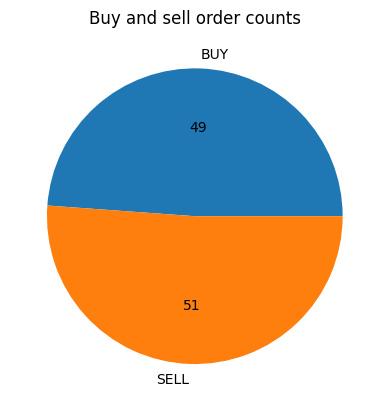

In [10]:
from matplotlib import pyplot as plt
buy_sell_counts = trades["side"].value_counts()
#px.bar(trades["side"].value_counts(), title="Trade counts")
plt.pie([len(trades[trades["side"]=="BUY"]),len(trades[trades["side"]=="SELL"])], 
        labels=["BUY","SELL"],
        autopct="%.0f")
plt.title("Buy and sell order counts")
plt.show()


In [11]:
import plotly.express as px
buy_profit = trades.loc[trades["side"]=="BUY","profit"]
sell_profit = trades.loc[trades["side"]=="SELL","profit"]
buy_profit = trades.loc[trades["side"]=="BUY","profit"]

#     q_low = df["low"].diff().quantile(0.01)
#     q_high  = df["high"].diff().quantile(0.99)
#     df=df[df["high"].diff()< q_high]
#     df=df[df["low"].diff() > q_low ]
px.bar(x=["buy_profit_sum", "sell_profit_sum"], y=[buy_profit.sum(), sell_profit.sum()], title="Buy or sell profit sum")

In [12]:
import plotly.express as px
buy_profit = trades.loc[trades["side"]=="BUY","profit"].mean()
sell_profit = trades.loc[trades["side"]=="SELL","profit"].mean()
px.bar(x=["buy_profit", "sell_profit"], y=[buy_profit, sell_profit], title="Buy or sell average trade profit")

## Trades on candlestick chart

In [13]:
from datetime import datetime
def get_last_candles():
    candle_columns = ["open_time", "open", "high", "low", "close", "vol", "close_time", "quote_asset_volume",
                      "number_of_trades", " taker_buy_base_asset_volume", "taker_buy_quote_asset_volume",
                      "ignore"]    
    end_date=trades.open_time.max() if not trades.empty else datetime.utcnow()
    
    #end_time_millis=end_date.value//1000000
    cnt=24*60 # Number of last candles to read
    raw_candles = client.klines(symbol=symbol,
                                    interval="1m",
                                    #limit=10,
                                    limit=cnt,
                                    #endTime=end_time_millis
                               )
    df = pd.DataFrame(raw_candles, columns=candle_columns)
    df["open_time"] = pd.to_datetime(df["open_time"], unit='ms')
    df["close_time"] = pd.to_datetime(df["close_time"], unit='ms')
    df.set_index("open_time", drop=False, inplace=True)
        # Convert strings to float prices
    df[["open", "high", "low", "close"]] = df[["open", "high", "low", "close"]].astype(float)
    return df

def clean_candles(df):
    """ Remove outliers """
    q_low = df["low"].diff().quantile(0.01)
    q_high  = df["high"].diff().quantile(0.99)
    df=df[df["high"].diff()< q_high]
    df=df[df["low"].diff() > q_low ]
    return df

candles = get_last_candles()
candles = clean_candles(candles)
candles.tail()

,open_time,open,high,low,close,vol,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
open_time,,,,,,,,,,,,
2023-05-04 18:33:00,2023-05-04 18:33:00,28722.62,28734.43,28717.44,28732.41,4.83160000,2023-05-04 18:33:59.999,138792.85138878,173,3.95351300,113570.59094357,0
2023-05-04 18:34:00,2023-05-04 18:34:00,28732.41,28749.07,28732.26,28749.07,3.17288700,2023-05-04 18:34:59.999,91189.13680236,104,2.92402900,84038.20937892,0
2023-05-04 18:35:00,2023-05-04 18:35:00,28749.69,28781.66,28748.19,28781.65,3.83898900,2023-05-04 18:35:59.999,110434.30780194,171,3.58998300,103271.49302016,0
2023-05-04 18:36:00,2023-05-04 18:36:00,28781.66,28793.54,28770.48,28786.99,6.10204300,2023-05-04 18:36:59.999,175603.46275468,197,3.50124300,100762.52169231,0
2023-05-04 18:37:00,2023-05-04 18:37:00,28789.90,28793.60,28789.90,28793.60,0.72423400,2023-05-04 18:37:59.999,20852.04132148,24,0.72371300,20837.04016327,0


In [14]:
# Install a conda package in the current Jupyter kernel
#%conda install -c plotly plotly=5.9.0
# Draw candlechart
import plotly as py
from plotly import graph_objects as go
import pandas as pd
import numpy as np
import datetime

def get_chart_figure(candles: pd.DataFrame, trades: pd.DataFrame)->pd.DataFrame:
    """
    Form plotly candlestick chart with buy/sell marks on it
    """
    
    df=candles.copy()
    #df=clean_candles(df)
    fig = go.Figure(data=[ \
                        go.Candlestick(\
                            x=df.index,\
                            open=df['open'],\
                            high=df['high'],\
                            low=df['low'],\
                            close=df['close'])
                         ])

    # Customize ay to distribute captions by y so they do not overlap by x
    ay,aymax,aystep=0,50,10
    #start_time=df.open_time.min()
    # Annotate buy, sell on the chart
    for i,trade in trades[(~trades.open_time.isna()) & (trades.open_time > df.open_time.min())].iterrows():
        ay=(ay+aystep)%aymax
        color='green' if trade['side']=="BUY" else 'red'

        # Draw open order
        open_text='buy' if trade['side']=="BUY"  else 'sell'
        open_hover=f"{trade['open_time']} {open_text} at {str(trade['open_price'])}"
        fig.add_annotation(x=trade['open_time'], \
                           y=trade['open_price'],\
                           text=open_text,\
                           hovertext=open_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,
                           font={'color':color}
                          )
    for i,trade in trades[(~trades.close_time.isna()) & (trades.close_time > df.close_time.min())].iterrows():
        color='green' if trade['side']=="BUY" else 'red'

        # Draw close order
        #profit = trade["close_price"]-trade["open_price"] if trade["close_price"] else None
        status= f", profit: {round(trade.profit, 10)}" if trade.profit else ""
        close_text='close buy' if trade['side']=="BUY"  else 'close sell'
        close_hover=f"{trade['close_time']} {close_text} at {str(trade['close_price'])}{status}"
        fig.add_annotation(x=trade['close_time'], \
                           y=trade['close_price'],\
                           text=close_text,\
                           hovertext=close_hover,\
                           showarrow=True,arrowhead=5,arrowcolor=color,ay=-ay,arrowwidth=2,
                           font={'color':color}
                          )
    return fig

get_chart_figure(candles, trades).show()



## Profit

In [15]:
import matplotlib.pyplot as plt
import plotly.express as px

profit=trades[["open_time", "profit"]].copy()


# mean = profit["profit"].mean()
# sd = profit["profit"].std()
# n_std=2
        
# profit = profit[(profit["profit"].abs() <= mean+(n_std*sd))]
profit["cum_profit"] = profit["profit"].cumsum()

In [16]:
px.line(trades, x="open_time", y="profit")


In [17]:

px.line(profit, x="open_time", y= "cum_profit")

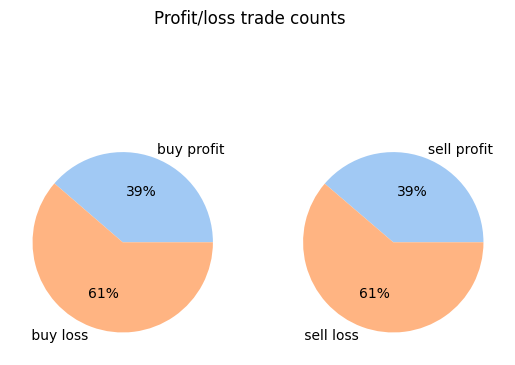

In [18]:
import seaborn as sns


colors = sns.color_palette('pastel')[0:5]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Profit/loss trade counts')
ax1.pie([len(trades[(trades["side"]=="BUY") &  (trades["profit"]>0)].index),\
        len(trades[(trades["side"]=="BUY") &  (trades["profit"]<0)].index) \
        ],
        labels=["buy profit", " buy loss"], autopct="%.0f%%", colors=colors)
ax2.pie([len(trades[(trades["side"]=="SELL") &  (trades["profit"]>0)].index),\
        len(trades[(trades["side"]=="SELL") &  (trades["profit"]<0)].index) \
        ],
        labels=["sell profit", " sell loss"], autopct="%.0f%%", colors=colors)


plt.show()
#trades[trades["profit"]>0].count()


In [19]:
trades[trades["profit"]>0]["profit"].median()
#trades[trades["profit"]<0]["profit"].median()

6.414999999999054

## Predicted and actual low/high

In [20]:
import os
import glob
import pandas as pd
from datetime import timedelta,date
import matplotlib.pyplot as plt
import plotly.express as px

def read_last_data(strategy):
    """ Read days from start to end from local predictions history"""
    
    def read_last(symbol: str, name: str, n: int):
        data_dir=f"./../data/{strategy}/Xy"
        file_path = sorted([f for f in os.listdir(data_dir) if f.endswith(f"{symbol}_{name}.csv")])[-1]
        return pd.read_csv(f"{data_dir}/{file_path}", parse_dates=True, index_col="datetime").tail(n)
    n=1000
    data=read_last("BTCUSDT", "data", n)
    X=read_last("BTCUSDT", "X", n)
    y=read_last("BTCUSDT", "y", n)
    data=pd.merge(data[["symbol"]],y, left_index=True, right_index=True) 
    #y=pd.concat([data,y])
    return data,X,y


# Read candles for last 3 days
data,_,_ = read_last_data(strategy)
data.tail()

,symbol,bid,ask,bid_max_fut,bid_min_fut,ask_min_fut,ask_max_fut,predict_window,open_signal,cur_trade
datetime,,,,,,,,,,
2023-05-04 18:36:23.274851,BTCUSDT,28727.31,28727.32,28728.987765,28722.754896,28722.631958,28728.577698,60s,0,-1
2023-05-04 18:36:23.274851,BTCUSDT,28727.31,28727.32,28728.975570,28722.739887,28722.612798,28728.564322,60s,0,-1
2023-05-04 18:36:23.382146,BTCUSDT,28727.31,28727.32,28728.987765,28722.754896,28722.631958,28728.577698,60s,0,-1
2023-05-04 18:36:23.382146,BTCUSDT,28727.31,28727.32,28728.975570,28722.739887,28722.612798,28728.564322,60s,0,-1
2023-05-04 18:36:23.485590,BTCUSDT,28727.31,28727.32,28728.975570,28722.739887,28722.612798,28728.564322,60s,0,-1


In [21]:

def get_predictions(data):
    """ 
    Merge predicted and real prices for analysis 
    """
    
    # Prediction window is constant, get it from last row
    predicted=data[["bid","ask","bid_min_fut", "bid_max_fut", "ask_min_fut", "ask_max_fut"]]
    predicted.columns=[c.replace("_fut", "_predicted") for c in predicted.columns]
    predict_window=data["predict_window"].tail(1).values[0]
    real_min=data[["bid", "ask"]].rolling(predict_window).min().rename(columns={"bid":"bid_min_real", "ask":"ask_min_real"})
    real_max=data[["bid", "ask"]].rolling(predict_window).max().rename(columns={"bid":"bid_max_real", "ask":"ask_max_real"})
    real=pd.concat([real_min, real_max], axis=1)
    real["prediction_datetime"]=real.index.to_series()-pd.to_timedelta(predict_window)
    merged=pd.merge_asof(real, predicted, left_on="prediction_datetime", right_index=True)
    return merged[["bid", "ask", "bid_min_real", "bid_min_predicted", "bid_max_real", "bid_max_predicted", \
                   "ask_min_real", "ask_min_predicted", "ask_max_real", "ask_max_predicted"]]


predictions = get_predictions(data)
predictions.tail()    


,bid,ask,bid_min_real,bid_min_predicted,bid_max_real,bid_max_predicted,ask_min_real,ask_min_predicted,ask_max_real,ask_max_predicted
datetime,,,,,,,,,,
2023-05-04 18:36:23.274851,NaN,NaN,28727.31,NaN,28727.34,NaN,28727.32,NaN,28727.35,NaN
2023-05-04 18:36:23.274851,NaN,NaN,28727.31,NaN,28727.34,NaN,28727.32,NaN,28727.35,NaN
2023-05-04 18:36:23.382146,NaN,NaN,28727.31,NaN,28727.34,NaN,28727.32,NaN,28727.35,NaN
2023-05-04 18:36:23.382146,NaN,NaN,28727.31,NaN,28727.34,NaN,28727.32,NaN,28727.35,NaN
2023-05-04 18:36:23.485590,NaN,NaN,28727.31,NaN,28727.34,NaN,28727.32,NaN,28727.35,NaN


## Prediction errors

In [22]:
px.line(predictions[["ask_max_real", "ask_max_predicted", "ask_min_real", "ask_min_predicted", \
                     "bid_max_real", "bid_max_predicted", "bid_min_real", "bid_min_predicted"]], \
        markers=True,title="Actual and predicted. Absolute values").show()


In [23]:
px.line(predictions[["ask_max_real", "ask_max_predicted", "ask_min_real", "ask_min_predicted", \
                     "bid_max_real", "bid_max_predicted", "bid_min_real", "bid_min_predicted"]]\
        .diff().add_suffix("_diff"), \
        markers=True,title="Actual and predicted. Absolute values").show()

In [24]:
errors=pd.DataFrame({\
                    "bid_min_error": predictions["bid_min_predicted"] - predictions["bid_min_real"], \
                    "bid_max_error": predictions["bid_max_predicted"] - predictions["bid_max_real"], \
                    "ask_min_error": predictions["ask_min_predicted"] - predictions["ask_min_real"], \
                    "ask_max_error": predictions["ask_max_predicted"] - predictions["ask_max_real"], \
                    })
px.line(errors, \
        title="Bid, ask prediction errors")


In [25]:

px.bar(errors.abs().sum(axis=1).rename("Error sum"), title="Prediction error total")

In [26]:
import pandas as pd

def get_profits(predictions: pd.DataFrame)->pd.DataFrame:
    """
    Buy, sell profit, real and predicted, for each time moment
    """
    
    profits = pd.DataFrame()
    # Profit/loss ratio to consider buy or sell
    min_ratio=2

    # Calculate possible profits for buy or sell
    profits["buy_profit_predicted"] = predictions["bid_max_predicted"] - predictions["ask"]
    profits["buy_loss_predicted"] = predictions["ask"]-predictions["bid_min_predicted"]
    profits['buy_ratio_predicted'] = np.where(profits['buy_loss_predicted'] > 0, profits['buy_profit_predicted'] / profits['buy_loss_predicted'],float('inf'))

    profits["buy_profit_real"] = predictions["bid_max_real"] - predictions["ask"]
    profits["buy_loss_real"] = predictions["ask"]-predictions["bid_min_real"]
    profits['buy_ratio_real'] = np.where(profits['buy_loss_real'] > 0, profits['buy_profit_real'] / profits['buy_loss_real'],float('inf'))


    profits["sell_profit_predicted"] = predictions["bid"] - predictions["ask_min_predicted"]
    profits["sell_loss_predicted"] = predictions["ask_max_predicted"] - predictions["bid"]
    profits['sell_ratio_predicted'] = np.where(profits['sell_loss_predicted'] > 0, profits['sell_profit_predicted'] / profits['sell_loss_predicted'],float('inf'))

    profits["sell_profit_real"] = predictions["bid"] - predictions["ask_min_real"]
    profits["sell_loss_real"] = predictions["ask_max_real"] - predictions["bid"]
    profits['sell_ratio_real'] = np.where(profits['sell_loss_real'] > 0, profits['sell_profit_real'] / profits['sell_loss_real'],float('inf'))


    profits["signal"] = np.where(profits['buy_ratio_predicted'] >= min_ratio, 1,
                                 np.where(profits["sell_ratio_predicted"]>=min_ratio, -1,0 ))

    # Calculate real profit or loss
    profits["profit_real"] = np.where(
        # If buy                             
        profits["signal"]==1,
        np.where(
            # Real movement down was inside what we predicted
            (predictions["bid_min_real"] < predictions["bid_min_predicted"]) 
            & (predictions["bid_max_real"] <= predictions["bid_max_predicted"]),
            # Take the profit
            profits["buy_profit_predicted"],
            # Or fix the loss
            -profits["buy_loss_predicted"]
        ),
        # If Sell                     
        np.where(profits["signal"] == -1,
            np.where(
                # Real movement down was inside what we predicted
                (predictions["ask_max_real"] > predictions["ask_max_predicted"]) 
                & (predictions["ask_min_real"] >= predictions["ask_max_predicted"]),
                # Take the profit
                profits["sell_profit_predicted"],
                # Or fix the loss
                -profits["sell_loss_predicted"]
            ),
            # If neither buy nor sell, return NaN
            np.nan
        )
    )

    # Fill in predicted profit
    profits["profit_predicted"]=np.where(profits["signal"] == 1, 
                                         # If buy
                                         profits["buy_profit_predicted"], 
                                        np.where(profits["signal"]==-1,
                                                # If sell
                                                profits["sell_profit_predicted"],
                                                # If neither buy not sell
                                                 np.nan))
    return profits

profits = get_profits(predictions)
pd.set_option('display.max_rows', 1000)
pd.concat([predictions,profits],axis=1).tail()
#profits.dropna().tail(100)




,bid,ask,bid_min_real,bid_min_predicted,bid_max_real,bid_max_predicted,ask_min_real,ask_min_predicted,ask_max_real,ask_max_predicted,buy_profit_predicted,buy_loss_predicted,buy_ratio_predicted,buy_profit_real,buy_loss_real,buy_ratio_real,sell_profit_predicted,sell_loss_predicted,sell_ratio_predicted,sell_profit_real,sell_loss_real,sell_ratio_real,signal,profit_real,profit_predicted
datetime,,,,,,,,,,,,,,,,,,,,,,,,,
2023-05-04 18:36:23.274851,NaN,NaN,28727.31,NaN,28727.34,NaN,28727.32,NaN,28727.35,NaN,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,1,NaN,NaN
2023-05-04 18:36:23.274851,NaN,NaN,28727.31,NaN,28727.34,NaN,28727.32,NaN,28727.35,NaN,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,1,NaN,NaN
2023-05-04 18:36:23.382146,NaN,NaN,28727.31,NaN,28727.34,NaN,28727.32,NaN,28727.35,NaN,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,1,NaN,NaN
2023-05-04 18:36:23.382146,NaN,NaN,28727.31,NaN,28727.34,NaN,28727.32,NaN,28727.35,NaN,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,1,NaN,NaN
2023-05-04 18:36:23.485590,NaN,NaN,28727.31,NaN,28727.34,NaN,28727.32,NaN,28727.35,NaN,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,NaN,NaN,inf,1,NaN,NaN


In [27]:
print(f"Total prediction profit sum: {profits['profit_real'].sum()}")



Total prediction profit sum: 0.0


In [28]:
#px.line(profits[["profit_predicted", "profit_real"]], markers=True)
px.line(profits["profit_predicted"]-profits["profit_real"])

## Sharp ratio

In [29]:
sharp_ratio_df=profits[["buy_ratio_predicted", "buy_ratio_real", "sell_ratio_predicted", "sell_ratio_real"]]
sharp_ratio_df.tail()


,buy_ratio_predicted,buy_ratio_real,sell_ratio_predicted,sell_ratio_real
datetime,,,,
2023-05-04 18:36:23.274851,inf,inf,inf,inf
2023-05-04 18:36:23.274851,inf,inf,inf,inf
2023-05-04 18:36:23.382146,inf,inf,inf,inf
2023-05-04 18:36:23.382146,inf,inf,inf,inf
2023-05-04 18:36:23.485590,inf,inf,inf,inf


In [30]:
px.line(sharp_ratio_df[["buy_ratio_predicted", "buy_ratio_real"]], title="Buy sharp ratio")

In [31]:
px.line(sharp_ratio_df[["sell_ratio_predicted", "sell_ratio_real"]], title="Sell sharp ratio")